In [1]:
import sys
sys.path.append("../code/")
from sklearn.metrics import mean_absolute_error
from dataloader import APPLIANCE_ORDER, get_train_test
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

torch.manual_seed(0)
np.random.seed(0)


weight_appliance = {'mw':1, 'dw':1, 'dr':1,'fridge':1, 'hvac':1}

# num_hidden, num_iterations, num_layers, p, num_directions = sys.argv[1:6]

In [3]:
appliance="mw"
cell_type = "GRU"
num_hidden = 120
num_iterations = 100
num_layers = 1
num_directions = 1

input_dim = 1
hidden_size = num_hidden
num_layers = num_layers
if num_directions == 1:
    bidirectional = False
else:
    bidirectional = True
lr = 0.1
p = 0.5
num_folds = 5
fold_num = 0

torch.manual_seed(0)

train, test = get_train_test(2, num_folds=num_folds, fold_num=fold_num)
train_aggregate = train[:, 0, None, :, :] - train[:, 1, None, :, :]
test_aggregate = test[:, 0, None, :, :]- test[:, 1, None, :, :]

In [4]:
t = Variable(torch.Tensor(train[:, 0, None, :, :]))
t.size()

torch.Size([54, 1, 112, 24])

In [ ]:
train_aggregate.shape

In [8]:
q = nn.Conv2d(1, 1, (1, 1), 1)
#r = nn.ConvTranspose2d(10, 1, (7, 1), 1)
q(t)
#r(q(t)).size()
#w = nn.BatchNorm2d(10)
#w(t)

Variable containing:
( 0 , 0 ,.,.) = 
   385.5894   385.7826   253.2901  ...   1414.7814  1315.7937   411.0408
   266.7957   251.2119   250.7973  ...   1150.2063   945.9730   258.0637
   298.5569   221.9341   171.7475  ...    702.6318   519.4344   383.3557
               ...                  ⋱                 ...               
   332.6178   234.9685   300.7906  ...    558.2547   562.9341   360.4867
   245.6702   304.3013   235.5622  ...    675.1399   477.2635   328.0421
   237.1927   314.9135   233.2956  ...    678.8957   703.7863   433.3727
      ⋮  

( 1 , 0 ,.,.) = 
    64.3200   267.3329    39.7734  ...    235.0250   118.2011   317.6844
   113.2720    68.4810    32.0498  ...    109.9026   429.0608    53.6230
    47.0304    46.3660    49.2546  ...    309.5508   198.4477    39.6980
               ...                  ⋱                 ...               
   141.5225   169.5704   107.9046  ...    442.9199   434.1125   181.2335
   101.8445   261.7205    53.2130  ...    322.9858   247.0

In [43]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        torch.manual_seed(0)

      
        self.q = nn.Conv2d(1, 100, (1, 1), 1)
        self.r = nn.ConvTranspose2d(100, 1, (1, 1), 1)
        self.act = nn.ReLU()
        #self.bn = nn.BatchNorm2d(50)
        self.act2 = nn.ReLU()
        
    def forward(self, x):
        
        pred = self.q(x)
        #pred = self.act(pred)
        #pred = self.bn(pred)
        pred = self.r(pred)
        pred = self.act2(pred)
        
        return pred

In [44]:
c = CustomCNN()
c

CustomCNN (
  (q): Conv2d(1, 100, kernel_size=(1, 1), stride=(1, 1))
  (r): ConvTranspose2d(100, 1, kernel_size=(1, 1), stride=(1, 1))
  (act): ReLU ()
  (act2): ReLU ()
)

In [45]:
train, test = get_train_test(2, num_folds=num_folds, fold_num=fold_num)


In [46]:
train.shape

(54, 6, 112, 24)

In [47]:
pd.DataFrame(train[:, :, None, :, :][0, :, 0, :])

ValueError: Must pass 2-d input

In [48]:
train_appliance = train[:, APPLIANCE_ORDER.index(appliance),None, :, :]
test_appliance = test[:, APPLIANCE_ORDER.index(appliance),None, :, :]

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.heatmap(train_appliance[5], cmap='Greens')
plt.figure()
sns.heatmap(train_aggregate[5],cmap='Greens')

ValueError: Must pass 2-d input

In [50]:
train_aggregate.shape

(54, 1, 112, 24)

In [51]:
loss_func = nn.L1Loss()
c = CustomCNN()
lr = 0.01
if cuda_av:
    c = c.cuda()
    loss_func = loss_func.cuda()
optimizer = torch.optim.Adam(c.parameters(), lr=lr)

In [52]:
inp = Variable(torch.Tensor(train_aggregate),
               requires_grad=True)
for t in range(num_iterations):
    out = Variable(torch.Tensor(train_appliance))
    if cuda_av:
        inp = inp.cuda()
        out = out.cuda()

    
    pred = c(inp)

    optimizer.zero_grad()
    

    
    loss = loss_func(pred, out)
    if t % 1 == 0:
        print(t, loss.data[0])

    loss.backward()
    optimizer.step()

0 9.146233558654785
1 9.14622974395752
2 9.14622974395752
3 9.14622974395752
4 9.14622974395752
5 9.14622974395752
6 9.14622974395752
7 9.14622974395752
8 9.14622974395752
9 9.14622974395752
10 9.14622974395752
11 9.14622974395752
12 9.14622974395752
13 9.14622974395752
14 9.14622974395752
15 9.14622974395752
16 9.14622974395752
17 9.14622974395752
18 9.14622974395752
19 9.14622974395752
20 9.14622974395752
21 9.14622974395752
22 9.14622974395752
23 9.14622974395752
24 9.14622974395752
25 9.14622974395752
26 9.14622974395752
27 9.14622974395752
28 9.14622974395752
29 9.14622974395752
30 9.14622974395752
31 9.14622974395752
32 9.14622974395752
33 9.14622974395752
34 9.14622974395752
35 9.14622974395752
36 9.14622974395752
37 9.14622974395752
38 9.14622974395752
39 9.14622974395752
40 9.14622974395752
41 9.14622974395752
42 9.14622974395752
43 9.14622974395752
44 9.14622974395752
45 9.14622974395752
46 9.14622974395752
47 9.14622974395752
48 9.14622974395752
49 9.14622974395752
50 9.1462

In [53]:
train_appliance.shape

(54, 1, 112, 24)

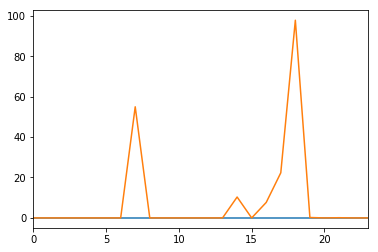

In [54]:
pd.Series(pred[0].data.numpy()[0, 0, :]).plot()
pd.Series(test_appliance[0, 0,0, :]).plot()

In [55]:
test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
test_out = Variable(torch.Tensor(test_appliance), requires_grad=False)


if cuda_av:
    test_inp = test_inp.cuda()
    
    

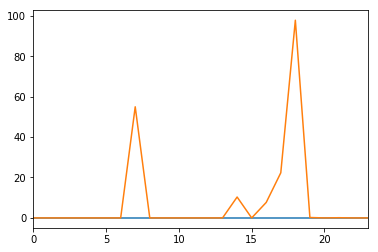

In [56]:
pd.Series(c(test_inp)[0].data.numpy()[0, 0, :]).plot()
pd.Series(test_out.data.numpy()[0, 0, 0, :]).plot()

In [41]:
p = c(test_inp)
p[p<0.] = 0.

In [42]:
loss_func(p, test_out)

Variable containing:
 8.9077
[torch.FloatTensor of size 1]

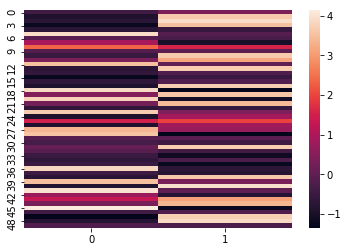

In [174]:
sns.heatmap(pd.DataFrame(list(c.parameters())[0].data.numpy().reshape(50, 2)))

In [ ]:
params = [test_inp, -2]
for i in range(len(ORDER)):
    params.append(None)
pr = a(*params)
pr = torch.clamp(pr, min=0.)
test_pred = torch.split(pr, test_aggregate.shape[0])
prediction_fold = [None for x in range(len(ORDER))]

if cuda_av:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].cpu().data.numpy().reshape(-1, 24)
else:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].data.numpy().reshape(-1, 24)
gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(test_aggregate.shape[0], -1,
                                                                                         1).reshape(-1, 24)


print([x.mean() for x in pred_split])
error = pd.Series({appliance:mean_absolute_error(gt_fold[appliance_num], prediction_fold[appliance_num]) for appliance_num, appliance in enumerate(ORDER)})